In [1]:
import sys
sys.path.append("/home/jzh/data_jzh/pints_related/gits_2/pySDC")

from pathlib import Path
import numpy as np
import statistics
import pySDC.helpers.plot_helper as plt_helper
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
from pySDC.projects.DAE.problems.ThreeInverterSystem import ThreeInverterSystem
from pySDC.projects.DAE.sweepers.fully_implicit_DAE import fully_implicit_DAE
# from pySDC.projects.DAE.misc.HookClass_DAE import approx_solution_hook
# from pySDC.projects.DAE.misc.HookClass_DAE import error_hook
from pySDC.implementations.hooks.log_solution import LogSolution

from pySDC.helpers.stats_helper import get_sorted
from pySDC.helpers.stats_helper import filter_stats


"""
A testing ground for the synchronous machine model
"""
# initialize level parameters
level_params = dict()
level_params['restol'] = 1e-7
level_params['dt'] = 1e-2

# initialize sweeper parameters
sweeper_params = dict()
sweeper_params['quad_type'] = 'RADAU-RIGHT'
sweeper_params['num_nodes'] = 3
sweeper_params['QI'] = 'LU'

# initialize problem parameters
problem_params = dict()
problem_params['newton_tol'] = 1e-3  # tollerance for implicit solver
problem_params['nvars'] = 30

# initialize step parameters
step_params = dict()
step_params['maxiter'] = 100

# initialize controller parameters
controller_params = dict()
controller_params['logger_level'] = 30
controller_params['hook_class'] = [LogSolution]

# Fill description dictionary for easy hierarchy creation
description = dict()
description['problem_class'] = ThreeInverterSystem
description['problem_params'] = problem_params
description['sweeper_class'] = fully_implicit_DAE
description['sweeper_params'] = sweeper_params
description['level_params'] = level_params
description['step_params'] = step_params

Path("data").mkdir(parents=True, exist_ok=True)

# instantiate the controller
controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)

# set time parameters
t0 = 0.0
Tend = 0.1

# get initial values on finest level
P = controller.MS[0].levels[0].prob
uinit = P.u_exact(t0)

# call main function to get things done...
uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)


# store results
sol = get_sorted(stats, type='approx_solution', sortby='time')
sol_dt = np.array([sol[i][0] for i in range(len(sol))])
sol_data = np.array([[sol[j][1][i] for j in range(len(sol))] for i in range(problem_params['nvars'])])
niter = filter_stats(stats, type='niter')
niter = np.fromiter(niter.values(), int)

t = np.array([me[0] for me in get_sorted(stats, type='u', sortby='time')])
# print([me[1][11*m + 2*m:11*m + 2*m + n] for me in get_sorted(stats, type='approx_solution', sortby='time', recomputed=False)])



In [2]:
# u_end = np.array([ me[1][:] for me in get_sorted(stats, type='u', sortby='time')])

In [5]:
# np.savetxt("some_i.txt",u_end/1000,delimiter=',')

In [2]:
i_c1 = np.array([ me[1][0:2] for me in get_sorted(stats, type='u', sortby='time')])
i_c2 = np.array([ me[1][8:10] for me in get_sorted(stats, type='u', sortby='time')])
i_c3 = np.array([ me[1][16:18] for me in get_sorted(stats, type='u', sortby='time')])

v_cc1 = np.array([ me[1][6:8] for me in get_sorted(stats, type='u', sortby='time')])
v_cc2 = np.array([ me[1][14:16] for me in get_sorted(stats, type='u', sortby='time')])
v_cc3 = np.array([ me[1][22:24] for me in get_sorted(stats, type='u', sortby='time')])

delta1 = np.array([ me[1][5] for me in get_sorted(stats, type='u', sortby='time')])
delta2 = np.array([ me[1][13] for me in get_sorted(stats, type='u', sortby='time')])
delta3 = np.array([ me[1][21] for me in get_sorted(stats, type='u', sortby='time')])

i_pccDQ = np.array([ me[1][24:26] for me in get_sorted(stats, type='u', sortby='time')])
il_12DQ = np.array([ me[1][26:28] for me in get_sorted(stats, type='u', sortby='time')])
il_23DQ = np.array([ me[1][28:30] for me in get_sorted(stats, type='u', sortby='time')])

i_g1DQ = i_pccDQ - il_12DQ
i_g2DQ = il_12DQ - il_23DQ
i_g3DQ = il_23DQ

i_g1=np.zeros_like(i_g1DQ)
i_g2=np.zeros_like(i_g2DQ)
i_g3=np.zeros_like(i_g3DQ)



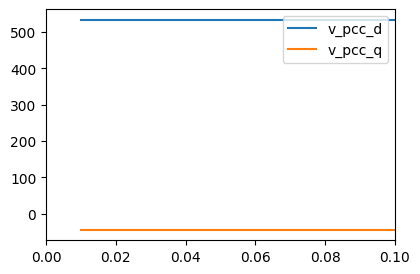

Done


In [3]:

for k in range(len(delta1)):
    rotation_matrix1 = np.array([[np.cos(delta1[k]), np.sin(delta1[k])], [-np.sin(delta1[k]), np.cos(delta1[k])]])
    i_g1[k, :] = np.dot(rotation_matrix1, i_g1DQ[k, :])

    rotation_matrix2 = np.array([[np.cos(delta2[k]), np.sin(delta2[k])], [-np.sin(delta2[k]), np.cos(delta2[k])]])
    i_g2[k, :] = np.dot(rotation_matrix2, i_g2DQ[k, :])

    rotation_matrix3 = np.array([[np.cos(delta3[k]), np.sin(delta3[k])], [-np.sin(delta3[k]), np.cos(delta3[k])]])
    i_g3[k, :] = np.dot(rotation_matrix3, i_g3DQ[k, :])

fs = 2000
Ts = 1/fs
Lf = 0.1e-3;    # L Filter
Kp  = Lf*1.8/(3*Ts)


v_g1 = Kp*(i_c1-i_g1) + v_cc1
v_g2 = Kp*(i_c2-i_g2) + v_cc2 
v_g3 = Kp*(i_c3-i_g3) + v_cc3 

# Initialize i_pcc as a zeros matrix with the same shape as i_pccDQ
i_pcc = np.zeros_like(i_pccDQ)

# Perform the matrix operations
for k in range(len(delta1)):
    rotation_matrix = np.array([[np.cos(delta1[k]), np.sin(delta1[k])],
                                [-np.sin(delta1[k]), np.cos(delta1[k])]])
    i_pcc[k, :] = np.dot(rotation_matrix, i_pccDQ[k, :])

# Set v_pcc to v_g1
v_pcc = v_g1

# Transpose i_pcc
i_pcc = i_pcc.T

file_name_suffix = "invSys"
fig, ax = plt_helper.plt.subplots(1, 1, figsize=(4.5, 3))
ax.plot(t, v_pcc[:, 0], label='v_pcc_d')
ax.plot(t, v_pcc[:, 1], label='v_pcc_q')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlim(0.0,0.1)
plt_helper.plt.show()
# fig.savefig(f'data/v_pcc_{file_name_suffix}.png', dpi=300, bbox_inches='tight')


print("Done")
